In [123]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

In [124]:
#Read in dataset
df = pd.read_csv("retail_store_inventory.csv")
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

(None,
          Date Store ID Product ID     Category Region  Inventory Level  \
 0  2022-01-01     S001      P0001    Groceries  North              231   
 1  2022-01-01     S001      P0002         Toys  South              204   
 2  2022-01-01     S001      P0003         Toys   West              102   
 3  2022-01-01     S001      P0004         Toys  North              469   
 4  2022-01-01     S001      P0005  Electronics   East              166   
 
    Units Sold  Units Ordered  Demand Forecast  Price  Discount  \
 0         127             55           135.47  33.50        20   
 1         150             66           144.04  63.01        20   
 2          65             51            74.02  27.99        10   
 3          61            164            62.18  32.72        10   
 4          14            135             9.26  73.64         0   
 
   Weather Condition  Holiday/Promotion  Competitor Pricing Seasonality  
 0             Rainy                  0               29.69    

In [125]:
#Checking missing value
df.isna().sum()

Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

In [126]:
#Checking duplicated Value
df.duplicated().sum()

0

In [127]:
#Check how many observations in Store, Product, Region
print(df['Store ID'].unique())
print(df['Product ID'].unique())
print(df['Region'].unique()) 

['S001' 'S002' 'S003' 'S004' 'S005']
['P0001' 'P0002' 'P0003' 'P0004' 'P0005' 'P0006' 'P0007' 'P0008' 'P0009'
 'P0010' 'P0011' 'P0012' 'P0013' 'P0014' 'P0015' 'P0016' 'P0017' 'P0018'
 'P0019' 'P0020']
['North' 'South' 'West' 'East']


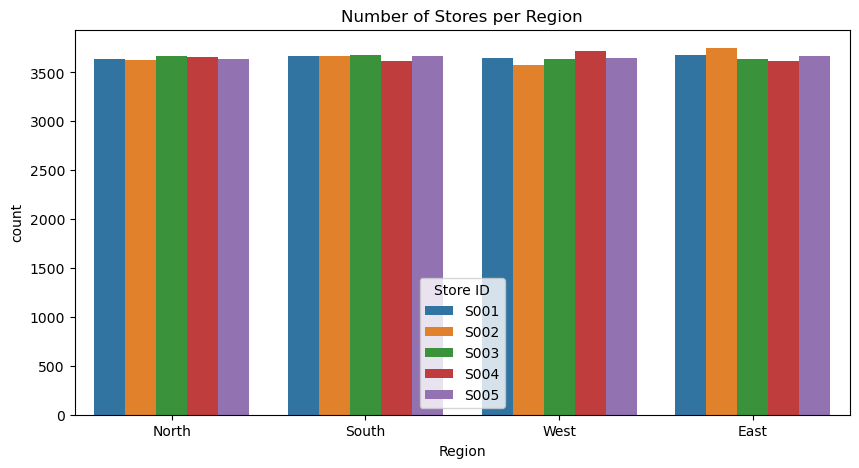

In [128]:
#Plotting to check whether a specific region or store outnumbers others
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Region', hue='Store ID')
plt.title('Number of Stores per Region')
plt.show()

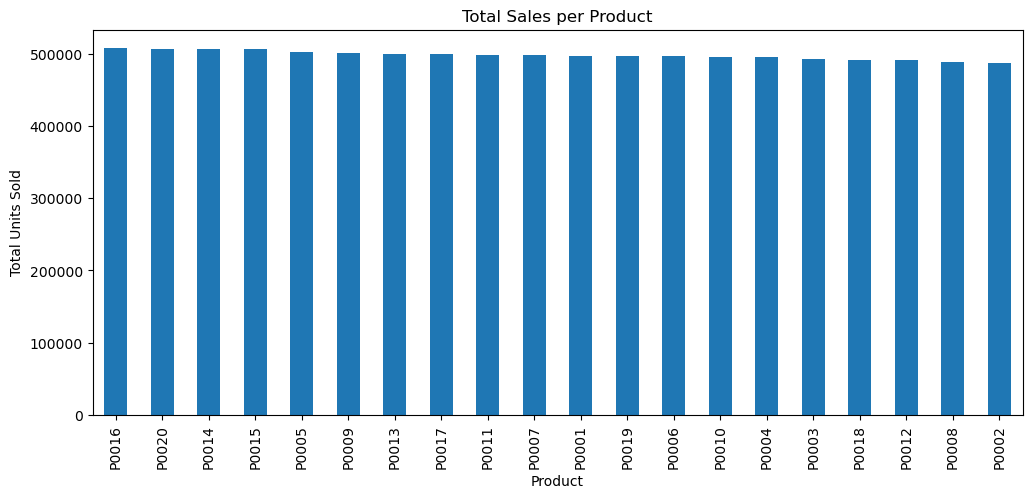

In [129]:
#Plotting to check if specific product outnumbers others
df.groupby('Product ID')['Units Sold'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(12,5))
plt.title('Total Sales per Product')
plt.xlabel('Product')
plt.ylabel('Total Units Sold')
plt.show()

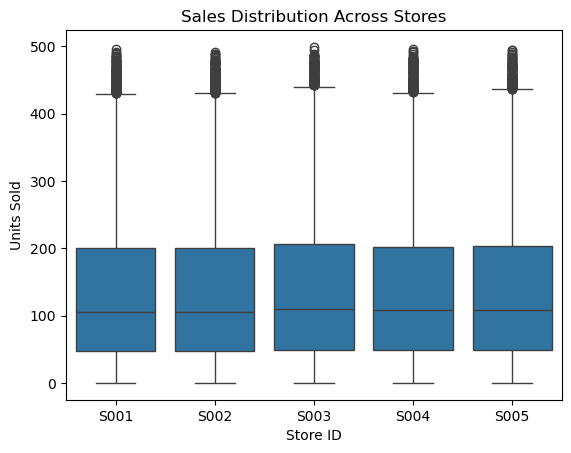

In [130]:
#Plotting to check how far the outliers located at
sns.boxplot(data=df, x='Store ID', y='Units Sold')
plt.title('Sales Distribution Across Stores')
plt.show()

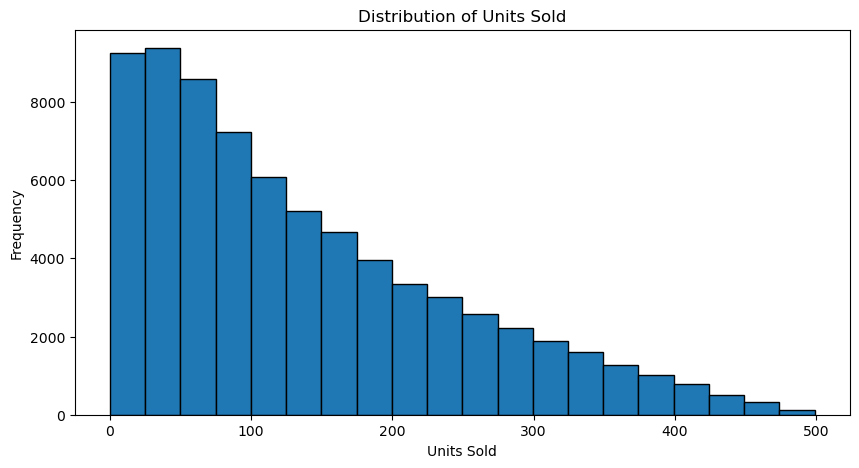

In [131]:
#Plotting to check the frequency of quantity of sales
plt.figure(figsize=(10, 5))
plt.hist(df['Units Sold'], bins=20, edgecolor='black')
plt.title('Distribution of Units Sold')
plt.xlabel('Units Sold')
plt.ylabel('Frequency')
plt.show()

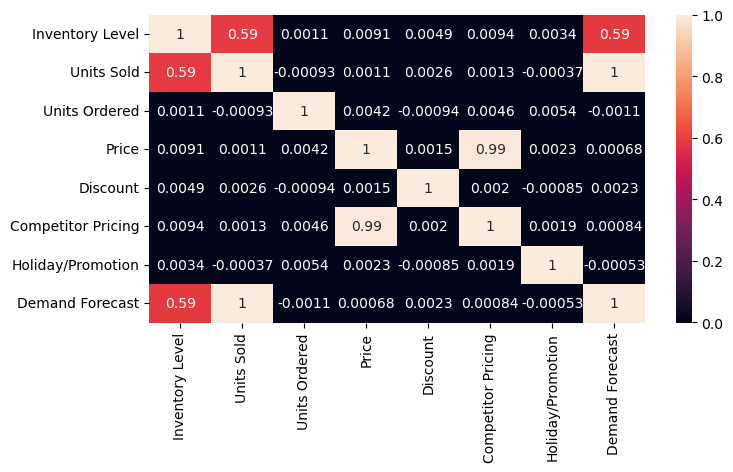

In [132]:
#Plotting to see the correlation betwwen variables
import seaborn as sns
numarical_columns = ['Inventory Level','Units Sold','Units Ordered','Price','Discount','Competitor Pricing','Holiday/Promotion','Demand Forecast']

corr_matrix = df[numarical_columns].corr()

plt.figure(figsize=(8,4))

sns.heatmap(corr_matrix, annot=True)

plt.show()

Based on the heatmap, there is a high correlation between units sold and demand forecast, as well as between price and competitor price. Additionally, while not very high, inventory level shows some correlation with units sold and demand forecast. Later, we will drop units sold and demand forecast after calculating the demand error, which is the difference between units sold and demand forecast. We will also drop price and competitor price to simplify the model.

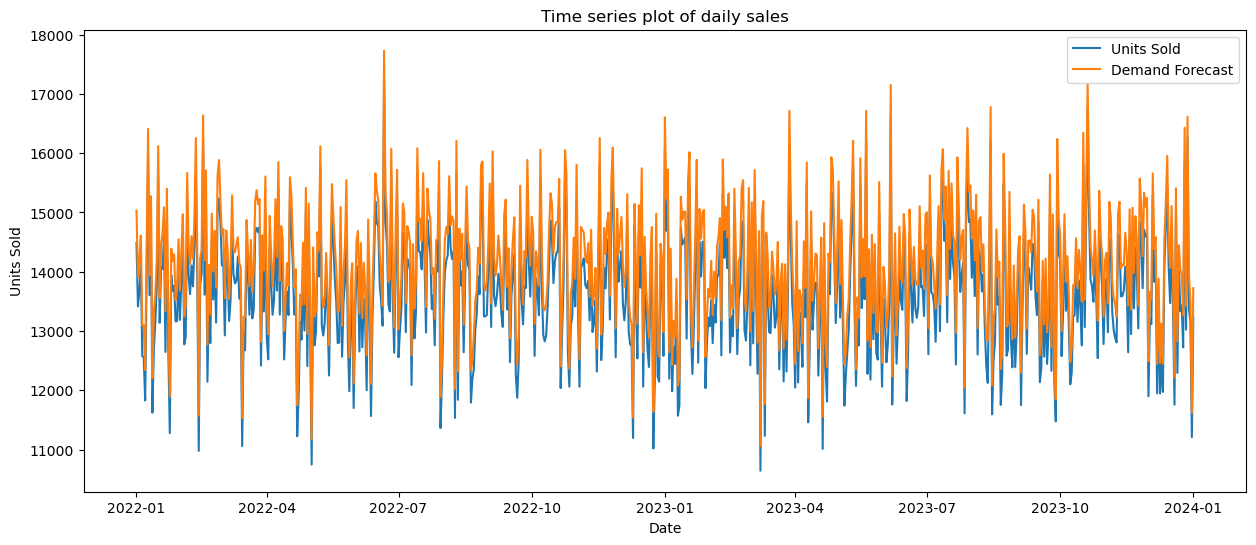

In [134]:
#convert data to datetime
df['Date']= pd.to_datetime(df['Date'])
daily_sales = df.groupby('Date')[['Units Sold', 'Demand Forecast']].sum().reset_index()

# Plot daily sales and demand forecast
plt.figure(figsize=(15, 6))
plt.plot(daily_sales['Date'], daily_sales['Units Sold'], label='Units Sold')
plt.plot(daily_sales['Date'], daily_sales['Demand Forecast'], label='Demand Forecast')   
plt.title('Time series plot of daily sales')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

<font size="5">After conducting exploratory data analysis (EDA) and data visualization, we found no significant differences in sales across products, stores, or regions. Therefore, we will focus only on one category of products in Store 1 within the East Region. To prepare the data, we are converting categorical variables into numerical values using One-Hot Encoding.</font> 

In [136]:
# Encode categorical columns first
filtered_df = pd.get_dummies(df, columns=['Weather Condition', 'Seasonality'], drop_first=True)
print(filtered_df.columns)

Index(['Date', 'Store ID', 'Product ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Holiday/Promotion', 'Competitor Pricing',
       'Weather Condition_Rainy', 'Weather Condition_Snowy',
       'Weather Condition_Sunny', 'Seasonality_Spring', 'Seasonality_Summer',
       'Seasonality_Winter'],
      dtype='object')


In [137]:
filtered_df[['Weather Condition_Rainy','Weather Condition_Snowy', 'Weather Condition_Sunny',
            'Seasonality_Spring', 'Seasonality_Summer', 'Seasonality_Winter']] = filtered_df[[
                'Weather Condition_Rainy','Weather Condition_Snowy', 'Weather Condition_Sunny',
                'Seasonality_Spring', 'Seasonality_Summer', 
                'Seasonality_Winter'
            ]].astype(int)

filtered_df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,0,29.69,1,0,0,0,0,0
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,0,66.16,0,0,1,0,0,0
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,1,31.32,0,0,1,0,1,0
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,1,34.74,0,0,0,0,0,0
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,0,68.95,0,0,1,0,1,0


In [138]:
#  Filter the data for the specified Store ID and Region
store_filter = (filtered_df["Store ID"] == "S001") & (filtered_df["Region"] == "East") & (filtered_df["Category"] == "Clothing")
filtered_df = filtered_df[store_filter]
filtered_df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
18,2022-01-01,S001,P0019,Clothing,East,352,257,186,267.38,73.28,10,0,77.26,0,0,0,0,0,1
107,2022-01-02,S001,P0008,Clothing,East,92,74,121,67.04,58.89,5,0,61.56,0,0,0,0,0,0
201,2022-01-03,S001,P0002,Clothing,East,282,199,70,193.26,54.02,0,0,52.91,0,0,0,1,0,0
211,2022-01-03,S001,P0012,Clothing,East,72,2,62,9.81,86.93,15,0,83.11,0,0,0,0,1,0
215,2022-01-03,S001,P0016,Clothing,East,148,31,160,35.11,93.61,15,1,94.15,0,1,0,1,0,0


In [139]:
# Columns needed to be droped
columns_to_drop = [
    "Store ID",
    "Product ID",
    "Category",
    "Region"
]

filtered_df = filtered_df.drop(columns=columns_to_drop, errors='ignore')
filtered_df.head()

,Date,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
18,2022-01-01,352,257,186,267.38,73.28,10,0,77.26,0,0,0,0,0,1
107,2022-01-02,92,74,121,67.04,58.89,5,0,61.56,0,0,0,0,0,0
201,2022-01-03,282,199,70,193.26,54.02,0,0,52.91,0,0,0,1,0,0
211,2022-01-03,72,2,62,9.81,86.93,15,0,83.11,0,0,0,0,1,0
215,2022-01-03,148,31,160,35.11,93.61,15,1,94.15,0,1,0,1,0,0


In [140]:
# Aggregate explicitly by 'Date' column
filtered_df = filtered_df.groupby('Date').agg({
    'Inventory Level': 'mean',
    'Units Sold': 'sum',
    'Units Ordered': 'sum',
    'Demand Forecast': 'sum',
    'Price': 'mean',
    'Discount': 'mean',
    'Holiday/Promotion': 'mean',
    'Competitor Pricing': 'mean',
    'Weather Condition_Rainy': 'mean',
    'Weather Condition_Snowy': 'mean',
    'Weather Condition_Sunny': 'mean',
    'Seasonality_Spring': 'mean',
    'Seasonality_Summer': 'mean',
    'Seasonality_Winter': 'mean'
})  

filtered_df.head()

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
Date,,,,,,,,,,,,,,
2022-01-01,352.000000,257,186,267.38,73.280000,10.0,0.000000,77.260000,0.0,0.000000,0.0,0.000000,0.000000,1.0
2022-01-02,92.000000,74,121,67.04,58.890000,5.0,0.000000,61.560000,0.0,0.000000,0.0,0.000000,0.000000,0.0
2022-01-03,167.333333,232,292,238.18,78.186667,10.0,0.333333,76.723333,0.0,0.333333,0.0,0.666667,0.333333,0.0
2022-01-04,77.000000,7,76,22.66,98.280000,15.0,1.000000,95.380000,0.0,0.000000,0.0,1.000000,0.000000,0.0
2022-01-06,342.500000,526,307,524.67,31.030000,12.5,1.000000,31.330000,0.0,0.000000,0.0,0.000000,0.000000,0.5


In [141]:
filtered_df = filtered_df.resample('D').sum().fillna(0)
filtered_df.head()

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
Date,,,,,,,,,,,,,,
2022-01-01,352.000000,257,186,267.38,73.280000,10.0,0.000000,77.260000,0.0,0.000000,0.0,0.000000,0.000000,1.0
2022-01-02,92.000000,74,121,67.04,58.890000,5.0,0.000000,61.560000,0.0,0.000000,0.0,0.000000,0.000000,0.0
2022-01-03,167.333333,232,292,238.18,78.186667,10.0,0.333333,76.723333,0.0,0.333333,0.0,0.666667,0.333333,0.0
2022-01-04,77.000000,7,76,22.66,98.280000,15.0,1.000000,95.380000,0.0,0.000000,0.0,1.000000,0.000000,0.0
2022-01-05,0.000000,0,0,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0


In [142]:
#Calculating and add Demand Error column to the dataset
filtered_df['Demand Error'] = filtered_df['Units Sold'] - filtered_df['Demand Forecast']
columns_to_drop = [
    "Units Sold",
    "Demand Forecast"
]
filtered_df = filtered_df.drop(columns=columns_to_drop, errors='ignore')
filtered_df.head()

,Inventory Level,Units Ordered,Price,Discount,Holiday/Promotion,Competitor Pricing,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter,Demand Error
Date,,,,,,,,,,,,,
2022-01-01,352.000000,186,73.280000,10.0,0.000000,77.260000,0.0,0.000000,0.0,0.000000,0.000000,1.0,-10.38
2022-01-02,92.000000,121,58.890000,5.0,0.000000,61.560000,0.0,0.000000,0.0,0.000000,0.000000,0.0,6.96
2022-01-03,167.333333,292,78.186667,10.0,0.333333,76.723333,0.0,0.333333,0.0,0.666667,0.333333,0.0,-6.18
2022-01-04,77.000000,76,98.280000,15.0,1.000000,95.380000,0.0,0.000000,0.0,1.000000,0.000000,0.0,-15.66
2022-01-05,0.000000,0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00


In [143]:
#spliting Training and testing data in chronological order
train_size = int(len(filtered_df) * 0.8)

train_df = filtered_df.iloc[:train_size]
test_df = filtered_df.iloc[train_size:]

# Target variable
y_train = train_df['Demand Error']
y_test = test_df['Demand Error']

#Adding noise to reduce overfitting
#noise_std = 0.01 * np.std(y_train)
#y_train_noisy = y_train + np.random.normal(0, noise_std, size=y_train.shape)

# Exogenous variables
exog_cols = ['Inventory Level', 
              'Price', 'Discount', 'Holiday/Promotion',
              'Competitor Pricing', 'Weather Condition_Rainy',
              'Weather Condition_Snowy', 'Weather Condition_Sunny',
              'Seasonality_Spring', 'Seasonality_Summer','Seasonality_Winter']

train_exog = train_df[exog_cols]
test_exog = test_df[exog_cols]

In [144]:
rf = RandomForestRegressor()
rf.fit(train_exog, y_train)

RandomForestRegressor()

In [145]:
y_pred = rf.predict(test_exog)

In [146]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae:.2f}")
print(f"Test MSE: {mse:.2f}")
print(f"Test R² Score: {r2:.2f}")

Test MAE: 5.92
Test MSE: 83.60
Test R² Score: 0.09


Hyperparameter tuning

In [148]:
param_grid = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [10, 20, 30, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 5],    
    'max_features': ['sqrt', 'log2']  
}

In [149]:
rf = RandomForestRegressor(random_state=42)

In [150]:
grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=5,  
    scoring='neg_mean_squared_error',  
    n_jobs=-1,  
    verbose=2  
)

In [151]:
grid_search.fit(train_exog, y_train)

# Get best parameters and best model
best_params = grid_search.best_params_  
best_model = grid_search.best_estimator_  

print("Best Parameters:", best_params)

#Correct: Use best_model for predictions
y_grid_pred = best_model.predict(test_exog)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [152]:
# Evaluate performance
mae = mean_absolute_error(y_test, y_grid_pred)
mse = mean_squared_error(y_test, y_grid_pred)
r2 = r2_score(y_test, y_grid_pred)

print(f"Test MAE: {mae:.2f}")
print(f"Test MSE: {mse:.2f}")
print(f"Test R² Score: {r2:.2f}")

Test MAE: 5.66
Test MSE: 76.69
Test R² Score: 0.17


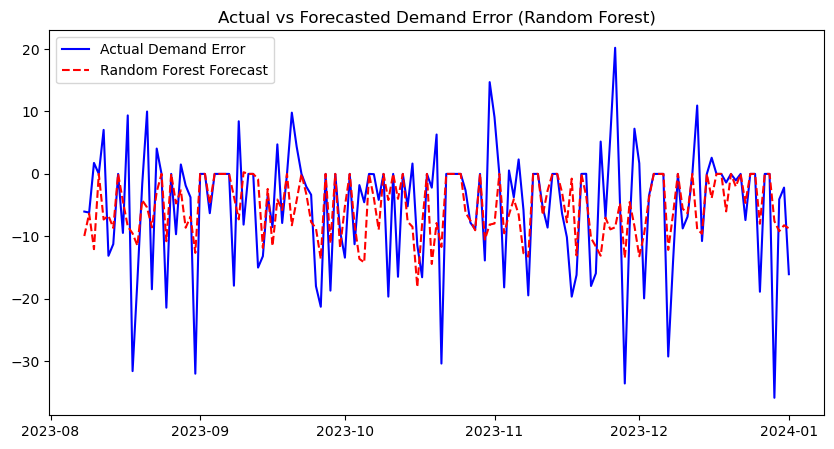

In [155]:
#ploting how model predicts 
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label="Actual Demand Error", color="blue")
plt.plot(y_test.index, y_grid_pred, label="Random Forest Forecast", color="red", linestyle="dashed")
plt.title("Actual vs Forecasted Demand Error (Random Forest)")
plt.legend()
plt.show()

After performing hyperparameter tuning using GridSearchCV, the model's performance improved.
This demonstrates that hyperparameter tuning significantly enhanced the model's accuracy by optimizing key parameters such as n_estimators, max_depth, min_samples_split, and min_samples_leaf.